In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import nltk
import re
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords, words
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer  # Correctly import PorterStemmer
import string
import pandas as pd
import numpy as np
from wordcloud import WordCloud
string.punctuation
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')

stop_words = set(stopwords.words('english'))
english_words = set(words.words())
stemmer = PorterStemmer()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
id2label = {i: label for i, label in enumerate(['Cancer', 'High_Bp', 'Diabetes'])}
from transformers import BloomConfig, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import nltk

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")

# Define config with num_labels
config = BloomConfig.from_pretrained("bigscience/bloom-560m")
config.update({"id2label": id2label, "num_labels": len(id2label)})

# Define the data loader
class DATALOADER(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure labels are 1D tensors
        return item

    def __len__(self):
        return len(self.labels)

# Read and preprocess the dataset
df = pd.read_csv('/content/drive/MyDrive/FinalADR.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.dropna()
df.head()

# Define preprocess function
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))
english_words = set(nltk.corpus.words.words())

def preprocess(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and word in english_words]
    return ' '.join(tokens)  # Convert tokens back to a single string

# Apply preprocessing to the text column
df['Clean'] = df['text'].apply(preprocess)

# Encode labels
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['disease'])

X=df.Clean
Y=df.label
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.33, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.225, random_state=42)
X_train = X_train.tolist()
y_train = y_train.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()
y_val=y_val.tolist()
X_val=X_val.tolist()
# Tokenize the data
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=170)
valid_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=170)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=170)

train_dataset = DATALOADER(train_encodings, y_train)
valid_dataset = DATALOADER(valid_encodings, y_val)
test_dataset = DATALOADER(test_encodings, y_test)

# Load the model for sequence classification



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

In [ ]:
! pip install peft

In [ ]:
print(model)

In [ ]:
from peft import get_peft_model, LoraConfig, TaskType


In [ ]:
# Function to create and apply LoRA configuration
def apply_lora(model, r, alpha, dropout):
    config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=r,
        lora_alpha=alpha,
        lora_dropout=dropout,
        target_modules=["query", "value"],
    )
    lora_model = get_peft_model(model, config)
    return lora_model

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("bigscience/bloom-560m", config=config)

def apply_best_lora(model):
    config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=8,
        lora_alpha=32,
        lora_dropout=0.2,
        target_modules=["query_key_value"],  # Update with correct modules
    )
    lora_model = get_peft_model(model, config)
    return lora_model

# Compute metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
    }
from transformers import AutoModelForSequenceClassification

# Load the base model

# Apply LoRA with best parameters
lora_model = apply_best_lora(model)

# Define training arguments with best hyperparameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    logging_steps=400,
    save_steps=400,
    learning_rate=0.001,
)

# Create Trainer instance
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of BloomForSequenceClassification were not initialized from the model checkpoint at bigscience/bloom-560m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
400,4.373100,1.025963,0.726962
800,0.949900,0.518864,0.791809
1200,0.447700,0.535419,0.832765
1600,0.268800,0.653783,0.836177


TrainOutput(global_step=1650, training_loss=1.4705647584163781, metrics={'train_runtime': 626.7869, 'train_samples_per_second': 42.072, 'train_steps_per_second': 2.632, 'total_flos': 1774425239838720.0, 'train_loss': 1.4705647584163781, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.7529220581054688,
 'eval_accuracy': 0.8327645051194539,
 'eval_runtime': 1.8133,
 'eval_samples_per_second': 161.586,
 'eval_steps_per_second': 10.478,
 'epoch': 10.0}

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.4912834167480469,
 'eval_accuracy': 0.7964250248262165,
 'eval_runtime': 7.6094,
 'eval_samples_per_second': 132.337,
 'eval_steps_per_second': 8.279,
 'epoch': 10.0}

In [ ]:
eval_results =trainer.evaluate(test_dataset)

# Predict on the evaluation dataset to get logits
predictions = trainer.predict(test_dataset)

In [ ]:
import numpy as np

# Extract true labels
true_labels = predictions.label_ids

# Extract predicted labels (argmax over logits)
preds = np.argmax(predictions.predictions, axis=1)

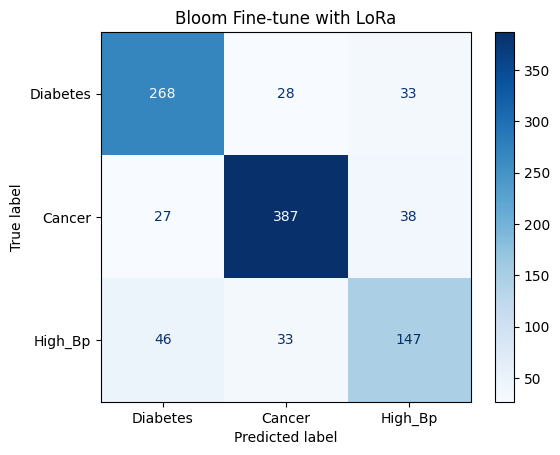

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
labels = ['Diabetes', 'Cancer', 'High_Bp']

# Compute the confusion matrix
cm = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)

plt.title('Bloom Fine-tune with LoRa')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# Assuming true_labels and preds are already defined
print(classification_report(true_labels, preds, target_names=labels))

              precision    recall  f1-score   support

    Diabetes       0.79      0.81      0.80       329
      Cancer       0.86      0.86      0.86       452
     High_Bp       0.67      0.65      0.66       226

    accuracy                           0.80      1007
   macro avg       0.77      0.77      0.77      1007
weighted avg       0.80      0.80      0.80      1007

